
### Exploratory Data Analysis (EDA) Structure for Car Dataset

**1. Univariate Distributions**
   - Price (raw and log transformed)
   - Mileage
   - Power (kw)
   - Year of manufacture

**2. Categorical Comparisons**
   - Price by Brand
   - Price by Fuel type
   - Price by Transmission
   - Price by Condition
   - Price by Emission Standard
   - Price by Engine Volume (bin)

**3. Price vs Year**
   - Overall scatter/boxplot
   - By top 6 brands

**4. Price vs Milaege**
   - Overall scatter/boxplot

**5. Liquidity and Depreciation Insights**
   - Brand-level depreciation curves for top 6 brands (Car age and Mileage)
   - Identify brands that hold value longer
   - Spot mileage thresholds where price drop accelerates

**6. Outlier Detection**
   - Suspiciously cheap or overpriced cars
   - Extreme mileage vs price mismatches (with and without brand influence)

**7. Correlation Heatmaps / Feature Relationships**
   - Price vs numerical features
   - Cross-tab of categorical features

**8. VIF Analysis for Multicollinearity**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook",style="whitegrid")
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
df = pd.read_csv("data/cleaned_automarket_autos.csv")
# Sanity check
print(df.shape)
print(df.dtypes)
print(df.head())
print(df.isna().sum())

(19182, 23)
Title                   object
Price                  float64
Year                   float64
Condition               object
Fuel                    object
Transmission            object
Body                    object
Drive                   object
Color                   object
EmissionStandard        object
SellerType              object
URL                     object
URL_canon               object
Brand                   object
Mileage_km             float64
Engine_cc              float64
Engine_l               float64
Power_kW               float64
Power_PS               float64
Fuel_collapsed          object
Engine_bin              object
Transmission_simple     object
Model_simple            object
dtype: object
                                  Title    Price    Year  Condition  \
0        mercedes e trieda 400 e 4matic  22000.0  2014.0  pouzivane   
1   ford kuga 2 0 tdci dpf titanium 4wd   8900.0  2011.0  pouzivane   
2          peugeot 308 1 6 hdi business   3999.0

In [3]:
# Mark price/mileage outliers (for plotting only)
p_lo, p_hi = df["Price"].quantile([0.01, 0.99])
m_lo, m_hi = 100, df["Mileage_km"].quantile(0.995)  # ignore ultra-low/ultra-high km in charts

df["is_price_outlier"] = (df["Price"] < p_lo) | (df["Price"] > p_hi)
df["is_km_outlier"]    = ~df["Mileage_km"].between(m_lo, m_hi)

# A trimmed view for visuals (keep both filters modest)
df_eda = df.loc[~(df["is_price_outlier"] | df["is_km_outlier"])].copy()

# Exclude crashed cars from EDA
df_eda = df_eda[df_eda["Condition"].str.lower() != "havarovane"].copy()

print(f"EDA view rows: {len(df_eda)} (of {len(df)})")


EDA view rows: 17902 (of 19182)


In [4]:
### 1. Univariate Distributions
# Vertical reference lines for median and IQR
def add_ref_lines(ax, series):
    s = series.dropna()
    med = s.median()
    q1, q3 = s.quantile([0.25, 0.75])
    ax.axvline(med, ls="--", lw=1, label=f"Median: {med:,.0f}")
    ax.axvline(q1, ls=":", lw=1, label=f"Q1: {q1:,.0f}")
    ax.axvline(q3, ls=":", lw=1, label=f"Q3: {q3:,.0f}")
    ax.legend(frameon=False, fontsize=9)



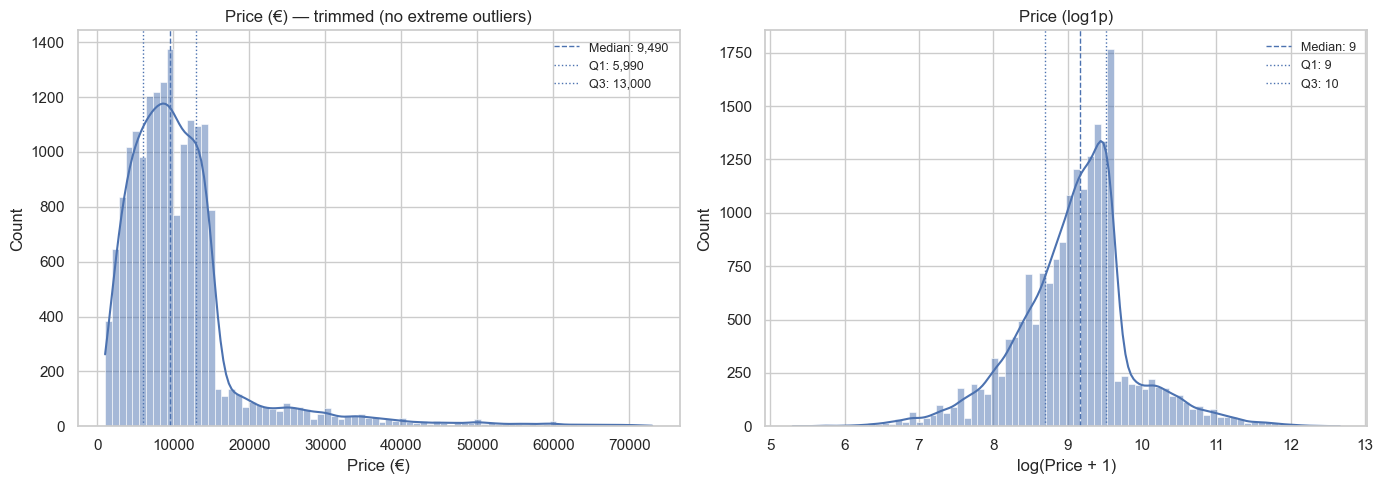

In [5]:
# Price
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_eda["Price"], bins=80, kde=True, ax=axes[0])
axes[0].set(title="Price (€) — trimmed (no extreme outliers)", xlabel="Price (€)", ylabel="Count")
add_ref_lines(axes[0], df_eda["Price"])

sns.histplot(np.log1p(df["Price"]), bins=80, kde=True, ax=axes[1])
axes[1].set(title="Price (log1p)", xlabel="log(Price + 1)", ylabel="Count")
add_ref_lines(axes[1], np.log1p(df["Price"]))
plt.tight_layout(); plt.show()



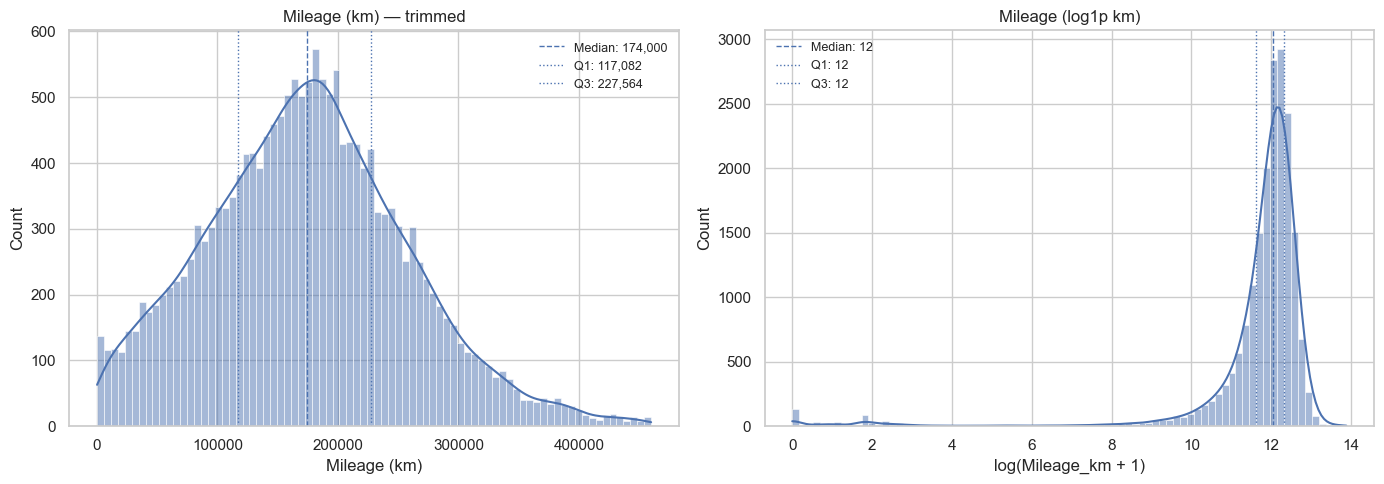

In [6]:
# Mileage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_eda["Mileage_km"], bins=80, kde=True, ax=axes[0])
axes[0].set(title="Mileage (km) — trimmed", xlabel="Mileage (km)", ylabel="Count")
add_ref_lines(axes[0], df_eda["Mileage_km"])

sns.histplot(np.log1p(df["Mileage_km"]), bins=80, kde=True, ax=axes[1])
axes[1].set(title="Mileage (log1p km)", xlabel="log(Mileage_km + 1)", ylabel="Count")
add_ref_lines(axes[1], np.log1p(df["Mileage_km"]))
plt.tight_layout(); plt.show()

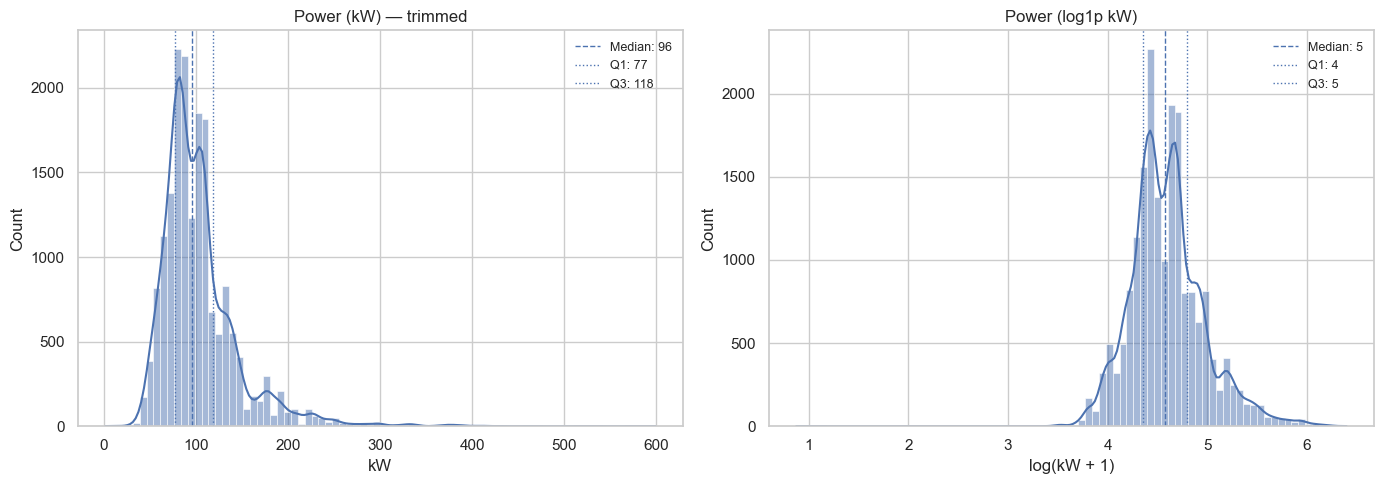

In [7]:
# Power
# kW is enough for EDA (PS is a linear transform)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_eda["Power_kW"], bins=80, kde=True, ax=axes[0])
axes[0].set(title="Power (kW) — trimmed", xlabel="kW", ylabel="Count")
add_ref_lines(axes[0], df_eda["Power_kW"])

sns.histplot(np.log1p(df["Power_kW"]), bins=80, kde=True, ax=axes[1])
axes[1].set(title="Power (log1p kW)", xlabel="log(kW + 1)", ylabel="Count")
add_ref_lines(axes[1], np.log1p(df["Power_kW"]))
plt.tight_layout(); plt.show()



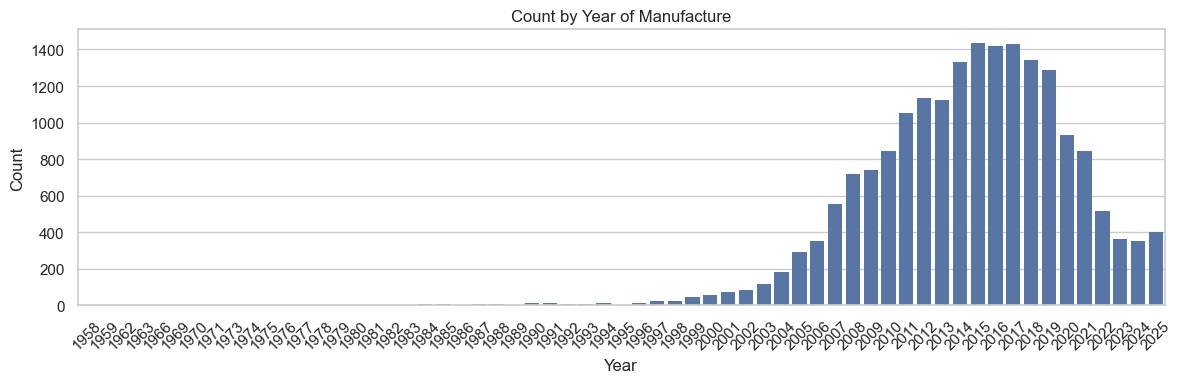


Price (trimmed) median / IQR: 9490.0 5990.0 13000.0
Mileage (trimmed) median / IQR: 174000.0 117081.5 227563.75
Power (trimmed) median / IQR: 96.0 77.0 118.0
Year: min/median/max: 1958 2015 2025


In [8]:
# Year
# Year is discrete, therefore bar chart of counts
year_counts = (
    df["Year"]
    .round(0).dropna().astype(int)
    .value_counts().sort_index()
)

plt.figure(figsize=(12, 4))
sns.barplot(x=year_counts.index, y=year_counts.values, linewidth=0)
plt.title("Count by Year of Manufacture")
plt.xlabel("Year"); plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Text summaries
print("\nPrice (trimmed) median / IQR:",
      df_eda["Price"].median(),
      df_eda["Price"].quantile(0.25),
      df_eda["Price"].quantile(0.75))
print("Mileage (trimmed) median / IQR:",
      df_eda["Mileage_km"].median(),
      df_eda["Mileage_km"].quantile(0.25),
      df_eda["Mileage_km"].quantile(0.75))
print("Power (trimmed) median / IQR:",
      df_eda["Power_kW"].median(),
      df_eda["Power_kW"].quantile(0.25),
      df_eda["Power_kW"].quantile(0.75))
print("Year: min/median/max:",
      int(df["Year"].min()), int(df["Year"].median()), int(df["Year"].max()))




### Notes:

I used df_eda for the “trimmed” plots to avoid being dominated by tails, and the log plots use full data to show the full distribution shape.

For Power, PS is redundant with kW, so one is enough.

For Year, bar counts are clearer than a continuous KDE.


In [9]:
### 2. Categorical Comparisons

# Function to plot boxplots + median table
def plot_categorical_price(df, cat_col, top_n=None, log_scale=False):
    plt.figure(figsize=(12,6))
    order = df.groupby(cat_col)["Price"].median().sort_values(ascending=False).index
    
    if top_n:
        order = order[:top_n]
        data = df[df[cat_col].isin(order)]
    else:
        data = df.copy()
    
    ax = sns.boxplot(
        data=data,
        x=cat_col, y="Price",
        order=order,
        showfliers=False
    )
    plt.title(f"Price by {cat_col} ({'log scale' if log_scale else '€'})")
    plt.xticks(rotation=45, ha="right")
    if log_scale:
        ax.set_yscale("log")
        plt.ylabel("Price (log scale)")
    else:
        plt.ylabel("Price (€)")
    plt.xlabel(cat_col)
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    summary = (
        df.groupby(cat_col)["Price"]
        .agg(["count","median","mean","min","max"])
        .sort_values("median", ascending=False)
    )
    print(f"\n=== Price summary by {cat_col} ===")
    print(summary.head(top_n if top_n else 20))
    return summary



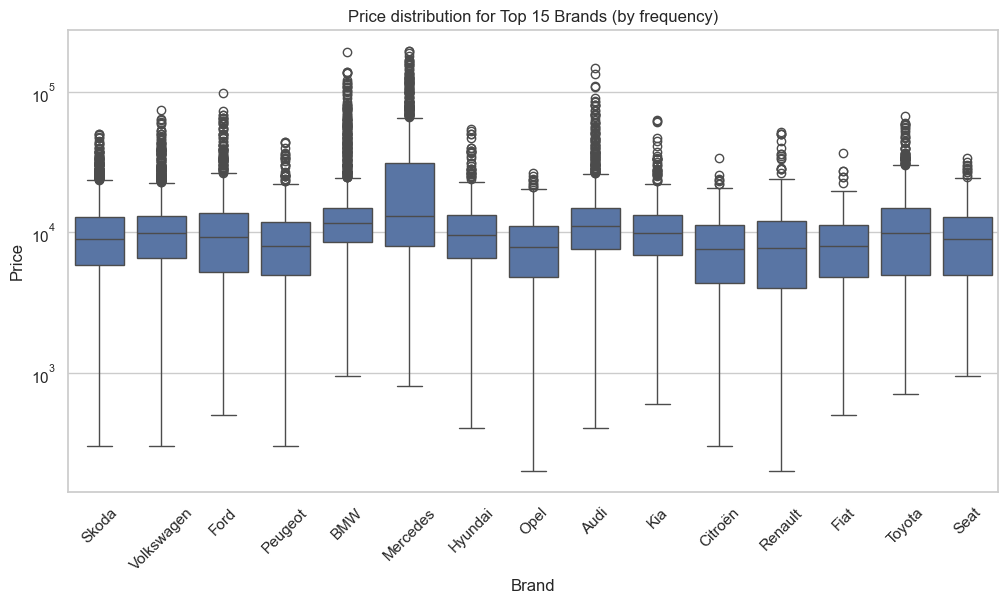

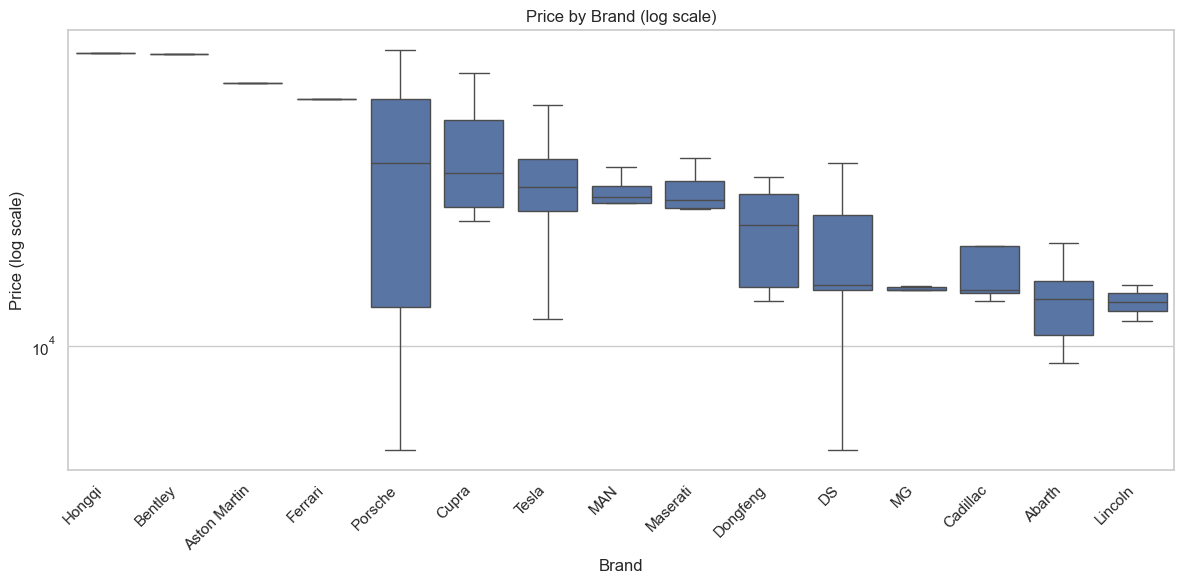


=== Price summary by Brand ===
              count    median          mean      min      max
Brand                                                        
Hongqi            1  70500.00  70500.000000  70500.0  70500.0
Bentley           1  70200.00  70200.000000  70200.0  70200.0
Aston Martin      1  58000.00  58000.000000  58000.0  58000.0
Ferrari           1  52000.00  52000.000000  52000.0  52000.0
Porsche          33  33900.00  33008.363636   5000.0  71990.0
Cupra            24  31720.58  35401.758750  22990.0  62024.0
Tesla            27  28800.00  31458.074074  11999.0  66490.0
MAN               5  26990.00  25792.000000  13990.0  33000.0
Maserati         10  26494.50  26992.700000  13490.0  34999.0
Dongfeng          7  22400.00  21670.000000  13500.0  30900.0
DS                5  15000.00  18495.600000   4990.0  33999.0
MG               10  14500.00  16464.000000   6600.0  35550.0
Cadillac          4  14500.00  19235.000000  13500.0  34440.0
Abarth            6  13645.00  13634.4

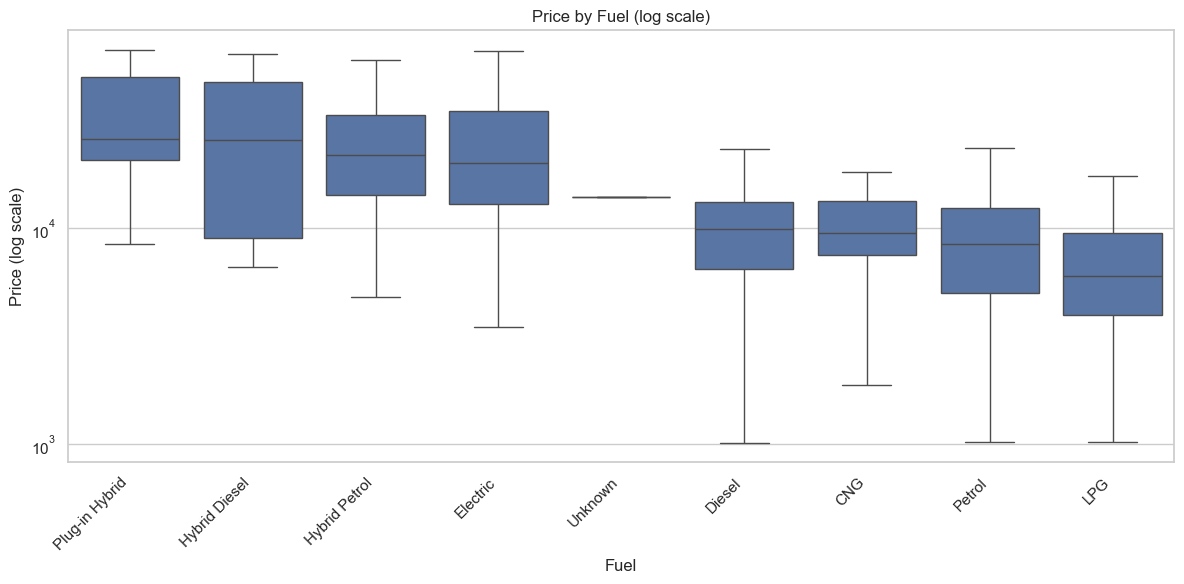


=== Price summary by Fuel ===
                count   median          mean       min      max
Fuel                                                           
Plug-in Hybrid     33  25990.0  34532.424242   8490.00  66900.0
Hybrid Diesel      17  25490.0  29390.470588   6590.00  63790.0
Hybrid Petrol     176  21745.0  25289.855227   4800.00  71990.0
Electric          260  19994.5  24402.960154   3500.00  70500.0
Unknown             1  13900.0  13900.000000  13900.00  13900.0
Diesel          10681   9900.0  11042.138421   1015.31  72900.0
CNG                57   9499.0   9947.631228   1890.00  18230.0
Petrol           6465   8499.0   9832.107319   1019.41  73000.0
LPG               212   5995.0   7363.957123   1022.62  68000.0


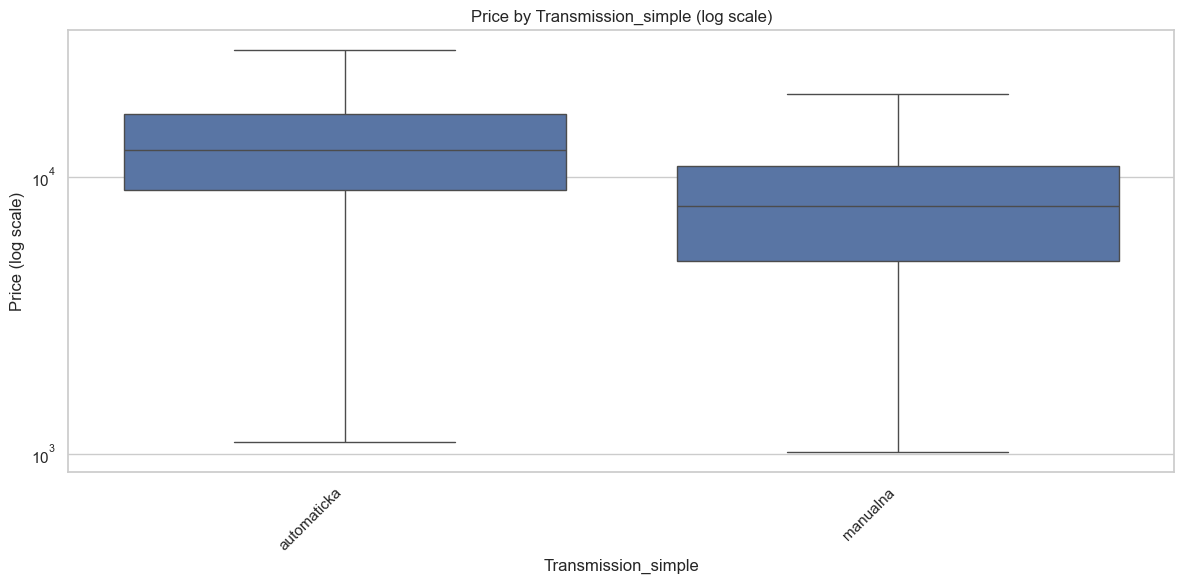


=== Price summary by Transmission_simple ===
                     count   median          mean      min      max
Transmission_simple                                                
automaticka           6492  12500.0  15702.025291  1100.00  73000.0
manualna             11410   7900.0   8251.110619  1015.31  60000.0


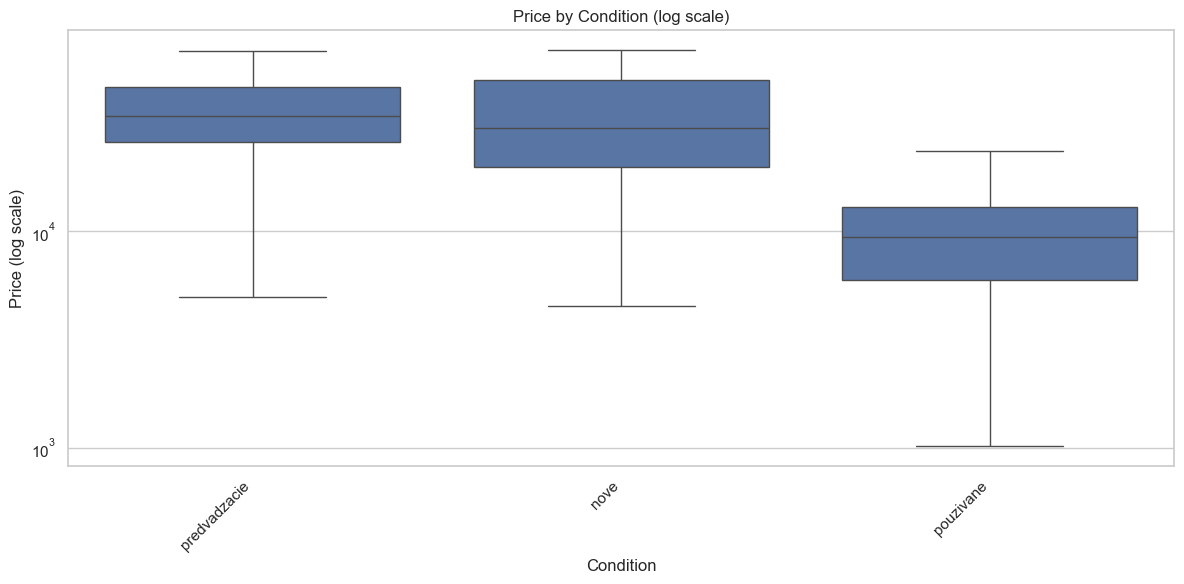


=== Price summary by Condition ===
              count   median          mean      min      max
Condition                                                   
predvadzacie    118  33990.0  35301.479492  5000.00  67990.0
nove             69  29950.0  33466.096377  4500.00  68825.0
pouzivane     17715   9400.0  10703.244997  1015.31  73000.0


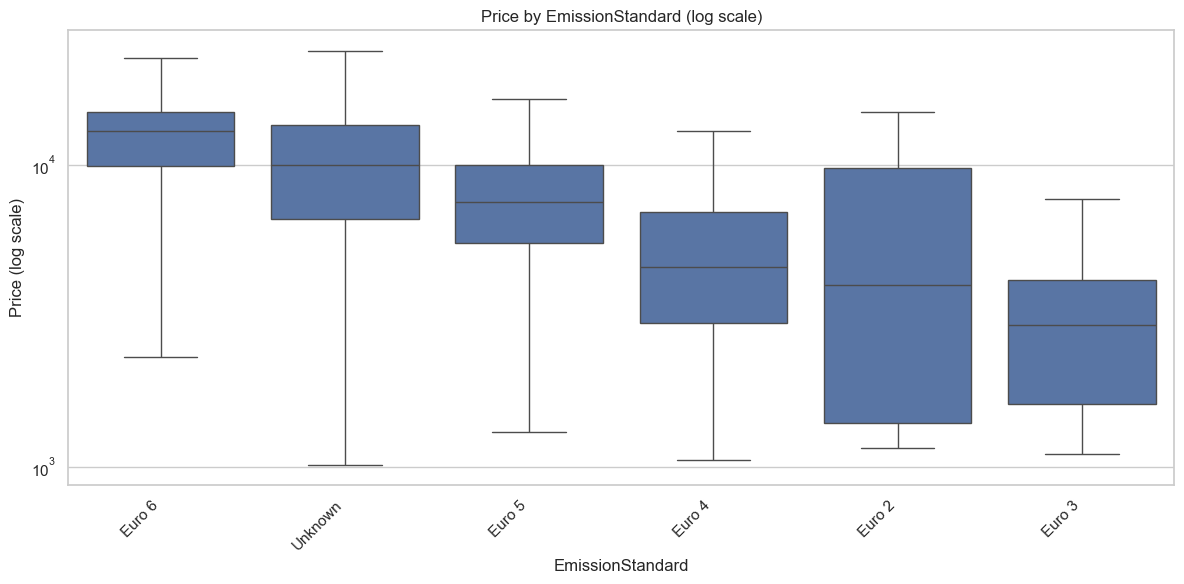


=== Price summary by EmissionStandard ===
                  count   median          mean      min      max
EmissionStandard                                                
Euro 6             4790  12900.0  15224.901342  1111.00  73000.0
Unknown            6644  10000.0  11615.857741  1015.31  72900.0
Euro 5             4143   7500.0   8088.985182  1300.00  69900.0
Euro 4             2176   4599.0   5445.054858  1050.00  59000.0
Euro 2               19   3990.0   5744.631579  1150.00  14999.0
Euro 3              130   2940.0   3918.700846  1100.00  59900.0


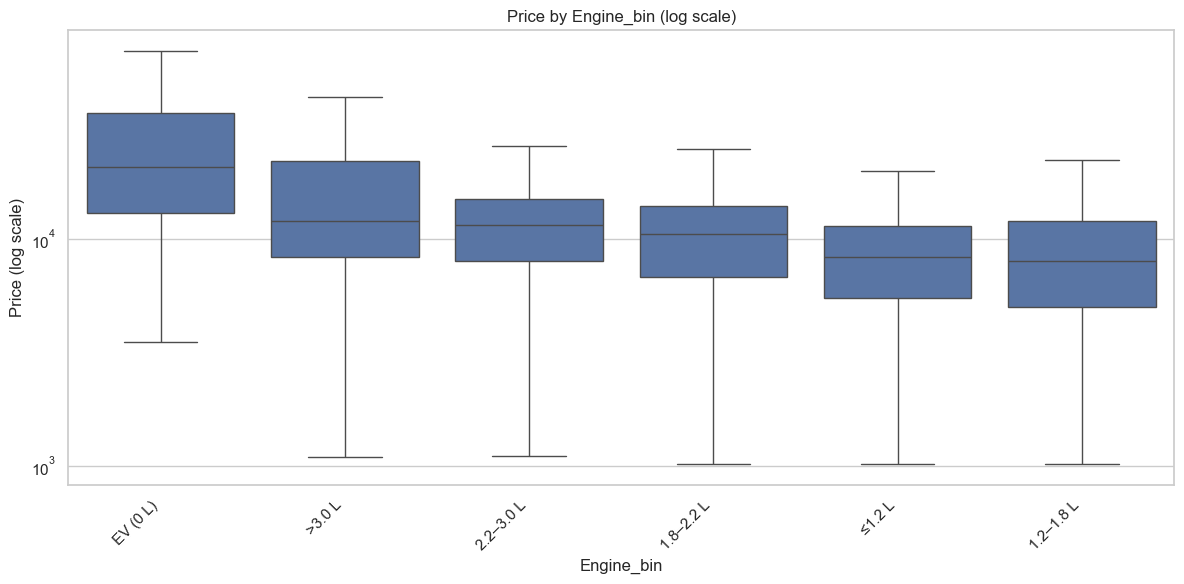


=== Price summary by Engine_bin ===
            count   median          mean      min      max
Engine_bin                                                
EV (0 L)      297  20690.0  25388.678923  3500.00  70500.0
>3.0 L        301  11999.0  18451.524784  1100.00  73000.0
2.2–3.0 L    1909  11500.0  15234.291273  1111.00  72900.0
1.8–2.2 L    6230  10490.0  11922.064793  1015.31  71990.0
≤1.2 L       2860   8300.0   8452.604332  1019.41  44990.0
1.2–1.8 L    6305   8000.0   8795.749351  1022.62  52900.0


In [10]:
# Price by Brand (Top 15 brands)
# Top 15 brands by frequency (not by price)
top_brands = df["Brand"].value_counts().index[:15]

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df[df["Brand"].isin(top_brands)],
    x="Brand", y="Price",
    order=top_brands
)
plt.yscale("log")
plt.title("Price distribution for Top 15 Brands (by frequency)")
plt.xticks(rotation=45)
plt.show()

# Top 15 by median price - premium view.
luxury_brand_summary = plot_categorical_price(df_eda, "Brand", top_n=15, log_scale=True)

# --- Price by Fuel ---
fuel_summary = plot_categorical_price(df_eda, "Fuel", log_scale=True)

# --- Price by Transmission (manual/auto) ---
trans_summary = plot_categorical_price(df_eda, "Transmission_simple", log_scale=True)

# --- Price by Condition (used/new/demo) ---
cond_summary = plot_categorical_price(df_eda, "Condition", log_scale=True)

# --- Price by Emission Standard ---
emis_summary = plot_categorical_price(df_eda, "EmissionStandard", log_scale=True)

# --- Price by Engine Volume (L in bins) ---
emis_summary = plot_categorical_price(df_eda, "Engine_bin", log_scale=True)

### Observations from Categorical Comparisons: 
**Brand:** Luxury brands such as Ferrari, Bentley, and Aston Martin dominate the upper price range, while common brands like Škoda, Volkswagen, and Ford show a much wider distribution that covers both affordable and mid-range prices.

**Fuel type:** Alternative fuel cars (electric, plug-in hybrids, and hybrid diesel/petrol) are on average more expensive than conventional petrol and diesel cars. LPG and CNG vehicles represent the cheapest segment.

**Emission standard:** Cars with newer emission standards (Euro 6) are generally more expensive, while older standards (Euro 2–4) are associated with cheaper vehicles.

**Condition:** New (“nove”) and demo cars (“predvadzacie”) clearly command the highest prices, while damaged cars (“havarovane”) are at the lower end of the price spectrum. Used cars (“pouzivane”) cover a wide range in between.

**Transmission:** Cars with automatic transmissions tend to be priced higher compared to those with manual gearboxes.

**Engine Volume:** The highest price have cars with electromotor, so the Engine volume is 0. Then naturally the price decreases with engine volume decreasing, because the bigger engine the more powerful car is. 


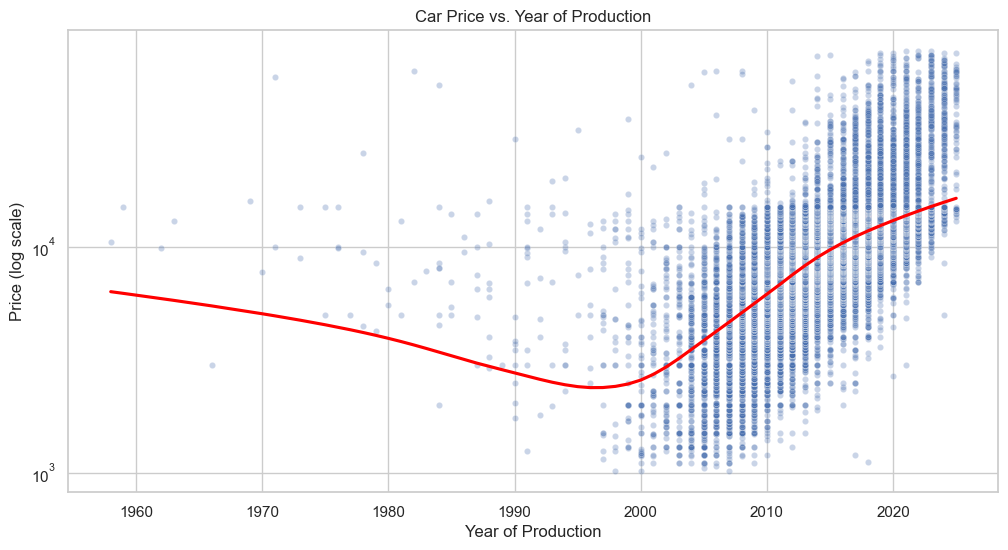

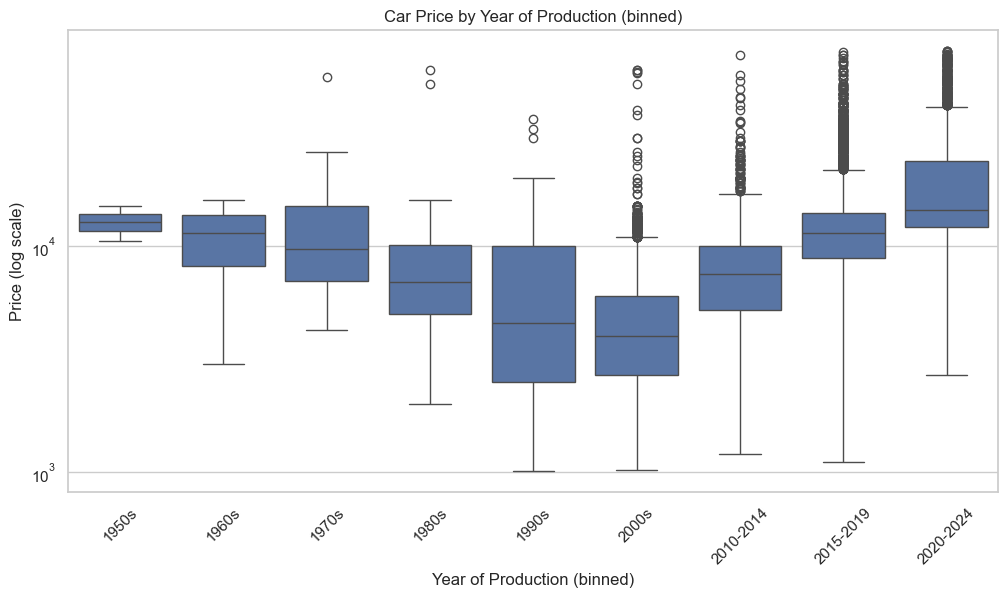

/var/folders/jm/0cc7ktkx6gj_h3njkpn3gh4r0000gn/T/ipykernel_20807/3318351326.py:88: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: safe_loess(


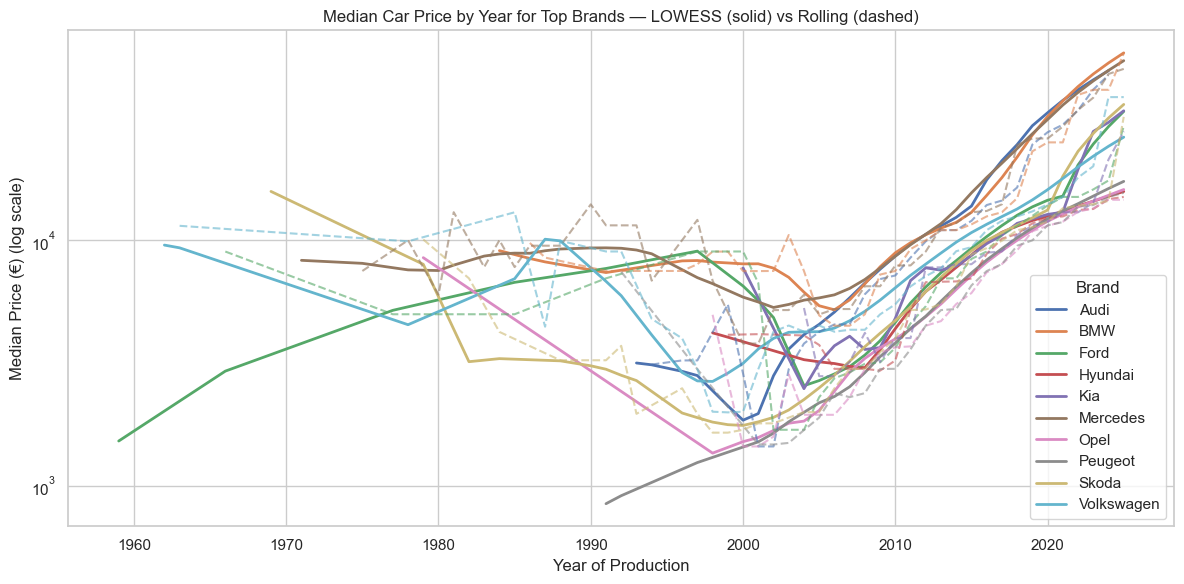

In [11]:
### 3. Price vs Year of Manufacture

# Overall scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_eda, 
    x="Year", 
    y="Price", 
    alpha=0.3,
    s=20
)

# Add regression/trendline with LOWESS smoothing
sns.regplot(
    data=df_eda,
    x="Year",
    y="Price",
    scatter=False,
    lowess=True,
    color="red"
)

plt.yscale("log")
plt.title("Car Price vs. Year of Production")
plt.xlabel("Year of Production")
plt.ylabel("Price (log scale)")
plt.show()

# Create bins (decades)
bins = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2015, 2020, 2025]
labels = ["1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010-2014", "2015-2019", "2020-2024"]

df_eda["Year_bin"] = pd.cut(df_eda["Year"], bins=bins, labels=labels, right=False)

# Plot binned Year vs Price
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_eda,
    x="Year_bin",
    y="Price",
)
plt.yscale("log")
plt.title("Car Price by Year of Production (binned)")
plt.xlabel("Year of Production (binned)")
plt.ylabel("Price (log scale)")
plt.xticks(rotation=45)
plt.show()

# Average Price by Brand-Year
# Brand–Year medians
brand_year = (
    df_eda.groupby(["Brand", "Year"], as_index=False)
          .agg(median_price=("Price", "median"),
               n=("Price", "size"))
)

# Focus on top brands by frequency (reuse the list you used for boxplots)
top_10brands = top_brands[:10]
by_top = brand_year[brand_year["Brand"].isin(top_10brands)].copy()
by_top.sort_values(["Brand", "Year"], inplace=True)

# Rolling median
by_top["roll_med"] = (
    by_top.groupby("Brand", group_keys=False)["median_price"]
          .transform(lambda s: s.rolling(window=3, min_periods=2).median())
)

# LOWESS
def safe_loess(g, frac=0.3, min_points=6):
    # drop missing, ensure monotonic x
    g = g.dropna(subset=["Year", "median_price"]).sort_values("Year").copy()
    if len(g) < min_points:
        g["loess"] = np.nan
        return g
    # LOWESS expects np arrays without NaNs
    yhat = sm.nonparametric.lowess(
        endog=g["median_price"].to_numpy(),
        exog=g["Year"].to_numpy(),
        frac=frac,
        return_sorted=False
    )
    g["loess"] = yhat
    return g

by_top = (
    by_top
    .groupby("Brand", group_keys=False)
    .apply(lambda g: safe_loess(
        g.drop(columns=["Brand"]).assign(Brand=g.name),  
        frac=0.25, min_points=6
    ))
    .reset_index(drop=True)
)

# Plot: rolling median + LOWESS (log scale)
plt.figure(figsize=(12,6))
# LOWESS lines (solid)
sns.lineplot(
    data=by_top.dropna(subset=["loess"]),
    x="Year", y="loess", hue="Brand", linewidth=2, legend=True
)
# Rolling median (dashed, lighter)
sns.lineplot(
    data=by_top.dropna(subset=["roll_med"]),
    x="Year", y="roll_med", hue="Brand", linestyle="--", alpha=0.6, legend=False
)
plt.yscale("log")
plt.title("Median Car Price by Year for Top Brands — LOWESS (solid) vs Rolling (dashed)")
plt.ylabel("Median Price (€) (log scale)")
plt.xlabel("Year of Production")
plt.tight_layout()
plt.show()

### Observations from Price vs Year Analysis:
* **The overall scatter plot shows a clear relationship between car price and year of production:**
Older cars (especially from the 1950s–1970s) often have higher prices due to being historical or collectible vehicles, rather than reflecting normal depreciation.
Cars from the 1980s–1990s generally occupy the lower end of the price spectrum, showing typical depreciation.
From ~2000 onwards, prices rise steadily, reflecting both newer cars being more expensive and the general trend of higher baseline prices for modern vehicles.
The LOWESS trend line confirms this U-shaped trajectory, with especially sharp increases for vehicles produced after ~2010.

* **When looking at the Brand-Year interaction:**
Premium brands (BMW, Mercedes, Audi) maintain higher price levels across all years compared to mass-market brands (Škoda, Opel, Peugeot).

* **Some brands show the same U-shaped curve:**
historical models (early years) can be expensive, middle-aged cars (1990s–2000s) are cheapest, and new cars (post-2010) are progressively more expensive.
The separation between premium and economy brands becomes more evident after ~2015, highlighting brand-driven price resilience.

* **Together**, these plots confirm that both age and brand positioning strongly shape resale values: newer models consistently command higher prices, premium brands retain stronger value, and very old historical cars often form a unique high-priced segment.

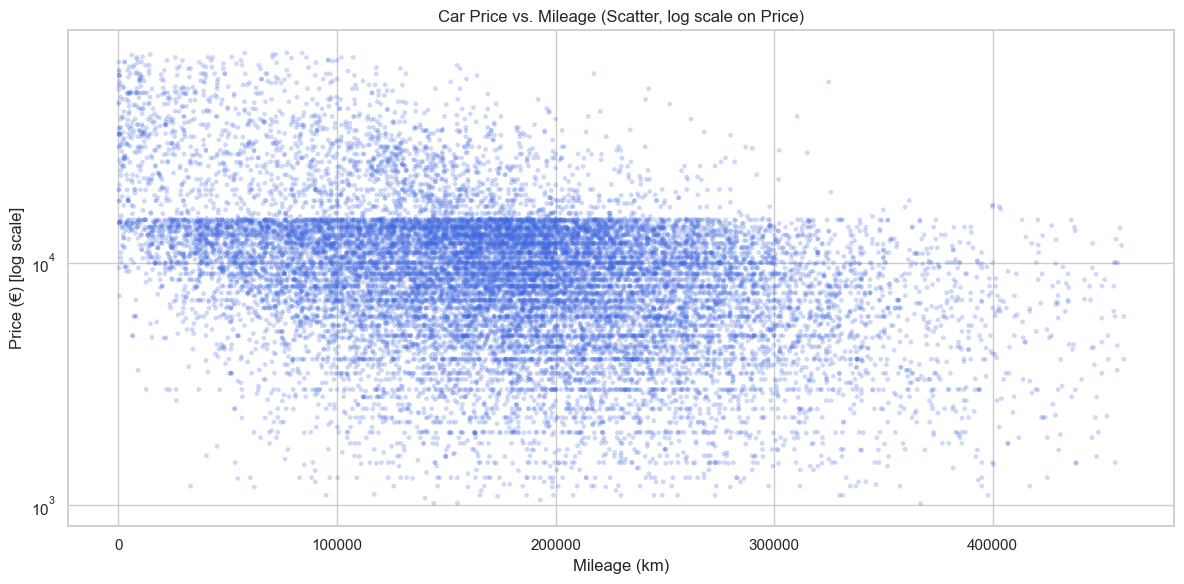

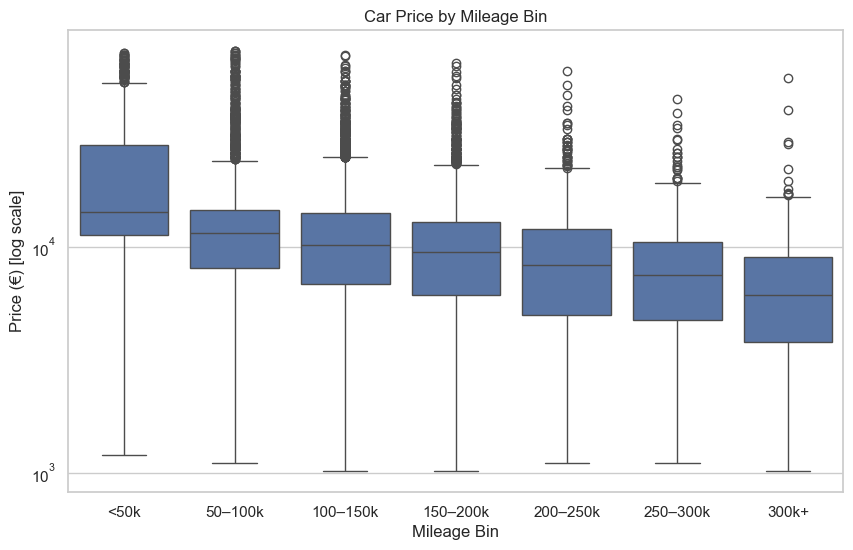

In [12]:
### 4. Price vs. Mileage
# Overall scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(
    df_eda["Mileage_km"], 
    df_eda["Price"],
    alpha=0.25, s=12, c="royalblue", edgecolor="none"
)
plt.yscale("log")
plt.xlabel("Mileage (km)")
plt.ylabel("Price (€) [log scale]")
plt.title("Car Price vs. Mileage (Scatter, log scale on Price)")
plt.tight_layout()
plt.show()


# Boxplot with binned mileage
df_eda["Mileage_bin_cat"] = pd.cut(
    df_eda["Mileage_km"],
    bins=[0, 50000, 100000, 150000, 200000, 250000, 300000, 500000],
    labels=["<50k", "50–100k", "100–150k", "150–200k", "200–250k", "250–300k", "300k+"]
)

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_eda, x="Mileage_bin_cat", y="Price"
)
plt.yscale("log")
plt.title("Car Price by Mileage Bin")
plt.xlabel("Mileage Bin")
plt.ylabel("Price (€) [log scale]")
plt.show()


### Observation from Price vs. Mileage:

**The relationship between mileage and price shows a clear depreciation pattern**

**Overall scatter plot:**

    Prices decline with mileage, though the relationship is noisy.
    Many new cars (mileage close to 0) command significantly higher prices, but the bulk of the used-car market clusters around 100k–250k km, where prices drop and variation is wider.

**Boxplots by mileage bins:**

    The median price consistently decreases across mileage bins.
    Cars with less than 50k km retain the highest prices.
    Beyond 200k km, depreciation slows down — prices stabilize at a lower level, with fewer high-priced outliers.



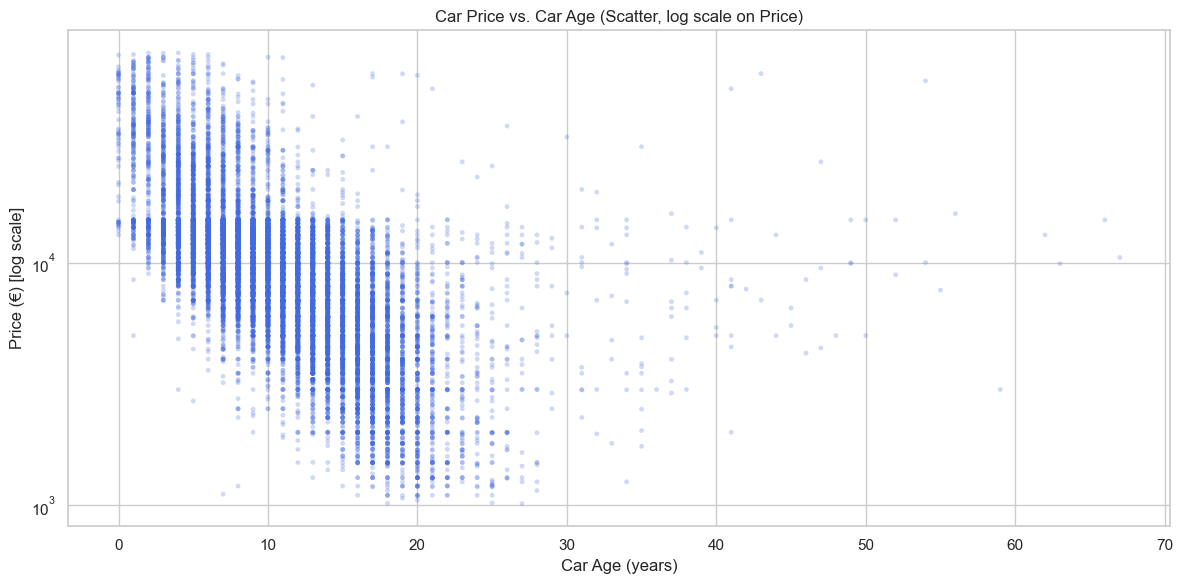

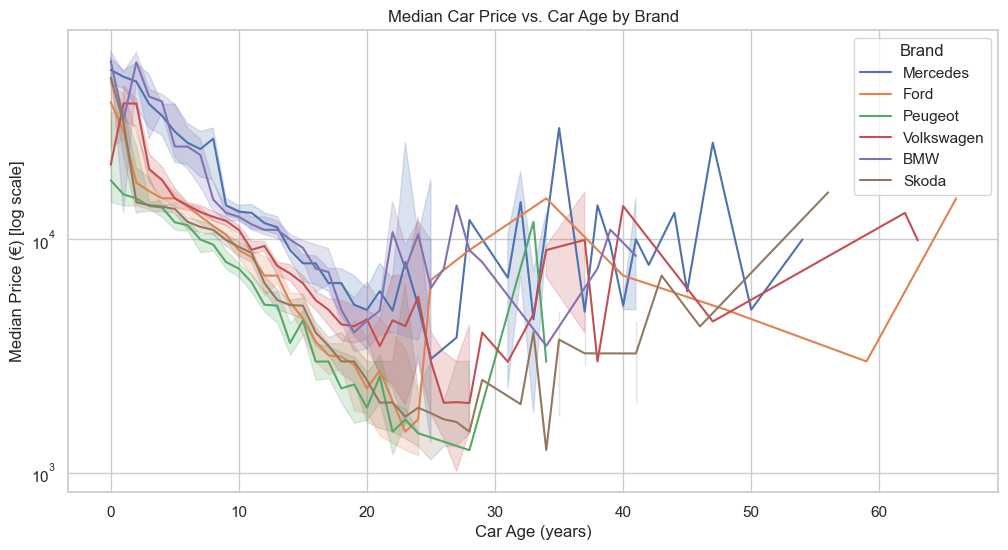

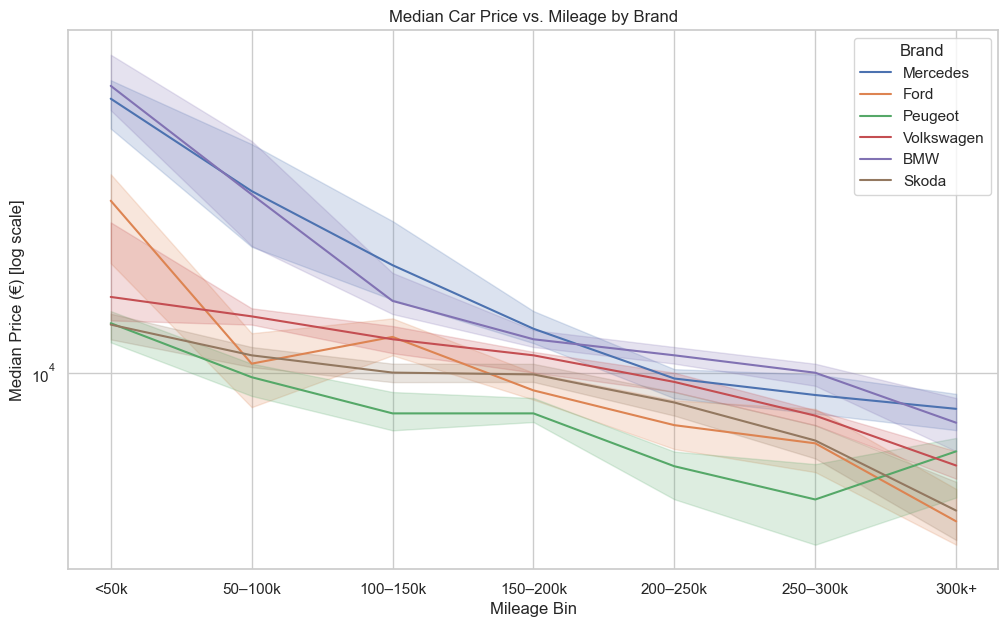

In [13]:
### 5. Liquidity & Depreciation Insights
# Price vs Car age
df_eda["Car_Age"] = 2025 - df_eda["Year"]
plt.figure(figsize=(12,6))
plt.scatter(
    df_eda["Car_Age"], 
    df_eda["Price"],
    alpha=0.25, s=12, c="royalblue", edgecolor="none"
)
plt.yscale("log")
plt.xlabel("Car Age (years)") 
plt.ylabel("Price (€) [log scale]")
plt.title("Car Price vs. Car Age (Scatter, log scale on Price)")
plt.tight_layout()
plt.show()

#Brand-level depreciation curves
top_6brands = top_brands[:6]
df_top6 = df_eda[df_eda["Brand"].isin(top_6brands)]

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_top6,
    x="Car_Age", y="Price",
    hue="Brand", estimator="median"
)
plt.yscale("log")
plt.title("Median Car Price vs. Car Age by Brand")
plt.xlabel("Car Age (years)")
plt.ylabel("Median Price (€) [log scale]")
plt.show()


plt.figure(figsize=(12,7))
sns.lineplot(
    data=df_top6, x="Mileage_bin_cat", y="Price",
    hue="Brand", estimator="median"
)
plt.yscale("log")
plt.title("Median Car Price vs. Mileage by Brand")
plt.xlabel("Mileage Bin")
plt.ylabel("Median Price (€) [log scale]")
plt.legend(title="Brand")
plt.show()


### Summarizing:

**Mercedes & BMW** hold value longer (age and mileage).

**50–100k km** and **150–200k km** are the two big cliffs where price drops accelerate across brands.

Mass-market brands are much more sensitive to these thresholds.

Suspiciously priced cars: 1140
Bin-wise IQR outliers: 830 / 17902
Brand+bin IQR outliers: 535 / 17902


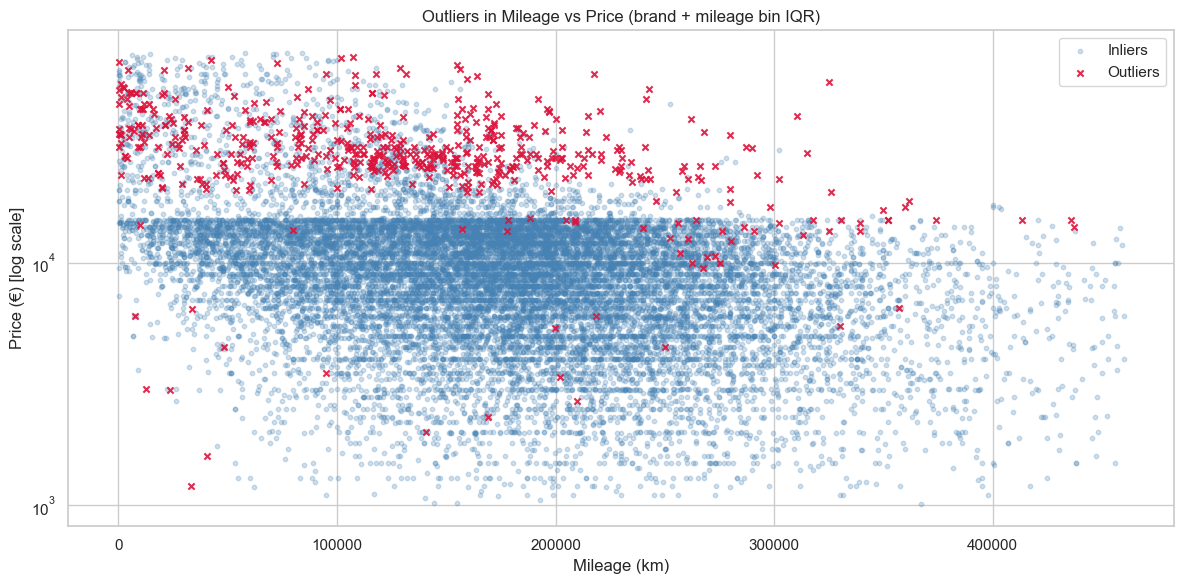

,Brand,Model_simple,Year,Mileage_km,Price,Mileage_bin_cat
673,BMW,Unknown,2022.0,107400.0,69999.0,100–150k
1320,Audi,Unknown,2014.0,102000.0,69900.0,100–150k
1170,Ford,Unknown,2021.0,42402.0,68000.0,<50k
3220,Toyota,Land Cruiser,2024.0,135.0,66971.0,<50k
949,Tesla,Unknown,2020.0,72327.0,66490.0,50–100k
866,Mercedes,Other,2019.0,155000.0,64900.0,150–200k
1792,Kia,Unknown,2024.0,32000.0,63000.0,<50k
1935,BMW,X7,2019.0,129000.0,63000.0,100–150k
55,Mercedes,GLE,2020.0,156349.0,62900.0,150–200k
187,Kia,Other,2025.0,4200.0,61990.0,<50k


,Brand,Model_simple,Year,Mileage_km,Price,Mileage_bin_cat
3380,Suzuki,Vitara,2017.0,33000.0,1200.0,<50k
3564,Fiat,Panda,2007.0,40300.0,1600.0,<50k
1201,Jaguar,Unknown,2005.0,140568.0,2000.0,100–150k
3995,SsangYong,Unknown,2000.0,169100.0,2300.0,150–200k
4215,Land Rover,Freelander,2002.0,209950.0,2700.0,200–250k
4400,Lada,Unknown,1990.0,23395.0,2990.0,<50k
4509,Citroën,C3,2009.0,12682.0,3000.0,<50k
4784,Land Rover,Freelander,2006.0,202000.0,3390.0,200–250k
4870,Mazda,2,2008.0,95000.0,3500.0,50–100k
5920,Lexus,IS,2000.0,249999.0,4500.0,200–250k


In [14]:
### 6. Outlier Detection
# Global IQR ckeck:
Q1, Q3 = df_eda["Price"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

outliers = df_eda[(df_eda["Price"] < lower) | (df_eda["Price"] > upper)]
print("Suspiciously priced cars:", len(outliers))

bin_edges  = [0, 50_000, 100_000, 150_000, 200_000, 250_000, 300_000, np.inf]
bin_labels = ["<50k","50–100k","100–150k","150–200k","200–250k","250–300k","300k+"]

if "Mileage_bin_cat" not in df_eda.columns:
    df_eda["Mileage_bin_cat"] = pd.cut(
        df_eda["Mileage_km"], bins=bin_edges, labels=bin_labels, right=False
    )

# Function to compute IQR bounds
def iqr_bounds(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return pd.Series({"lower": q1 - k*iqr, "upper": q3 + k*iqr})

# Mileage-wise IQR outliers: is the price odd for this mileage bracket?
bin_bounds = (
    df_eda.groupby("Mileage_bin_cat", observed=True)["Price"]
          .apply(iqr_bounds)
          .reset_index()
          .pivot(index="Mileage_bin_cat", columns="level_1", values="Price")
          .rename_axis(None, axis=1)
)

df_out = df_eda.join(bin_bounds, on="Mileage_bin_cat")
df_out["outlier_bin"] = (df_out["Price"] < df_out["lower"]) | (df_out["Price"] > df_out["upper"])

print("Bin-wise IQR outliers:", df_out["outlier_bin"].sum(), "/", len(df_out))

# Brand+Mileage IQR outliers: is the price odd for "this brand" at "this mileage"?
bm_bounds = (
    df_eda.groupby(["Brand", "Mileage_bin_cat"], observed=True)["Price"]
          .apply(iqr_bounds)
          .reset_index()
          .pivot(index=["Brand","Mileage_bin_cat"], columns="level_2", values="Price")
          .rename_axis(None, axis=1)
)

df_out = (
    df_out.set_index(["Brand","Mileage_bin_cat"])
          .join(bm_bounds, rsuffix="_bm")
          .reset_index()
)

# Some (brand,mileage) groups may be too small => NaNs; treat them as not-outliers
df_out["outlier_brandmileage"] = (
    (df_out["Price"] < df_out["lower_bm"]) | (df_out["Price"] > df_out["upper_bm"])
)
df_out["outlier_brandmileage"] = df_out["outlier_brandmileage"].fillna(False)

print("Brand+bin IQR outliers:", df_out["outlier_brandmileage"].sum(), "/", len(df_out))

# Plot: mileage vs price with brand+mileage outliers highlighted
plt.figure(figsize=(12,6))
plt.scatter(
    df_out.loc[~df_out["outlier_brandmileage"], "Mileage_km"],
    df_out.loc[~df_out["outlier_brandmileage"], "Price"],
    s=10, alpha=0.25, color="steelblue", label="Inliers"
)
plt.scatter(
    df_out.loc[df_out["outlier_brandmileage"], "Mileage_km"],
    df_out.loc[df_out["outlier_brandmileage"], "Price"],
    s=20, alpha=0.9, color="crimson", marker="x", label="Outliers"
)
plt.yscale("log")
plt.xlabel("Mileage (km)")
plt.ylabel("Price (€) [log scale]")
plt.title("Outliers in Mileage vs Price (brand + mileage bin IQR)")
plt.legend()
plt.tight_layout()
plt.show()

# Inspect a few most suspicious cases
cols_show = ["Brand","Model_simple","Year","Mileage_km","Price","Mileage_bin_cat"]
display(
    df_out.loc[df_out["outlier_brandmileage"]]
          .sort_values("Price", ascending=False)
          .head(15)[cols_show]
)
display(
    df_out.loc[df_out["outlier_brandmileage"]]
          .sort_values("Price", ascending=True)
          .head(15)[cols_show]
)


### Observations:
**Global IQR check** flagged 1140 cars, which is expected, since price distribution is heavy-tailed, and blunt rules like this tend to scream "outlier" a lot.

**Mileage-only** IQR brought the number down to 830. This makes sense: a €5k car with 20k km is not the same story as a €5k car with 300k km. Context matters.

**Brand and Mileage bin** IQR is the most informative. Only ~530 cars look suspicious. This feels realistic, it highlights unusual listings like:

* luxury SUVs priced way too high despite heavy mileage,
* beat-up older cars priced weirdly low,
* and some edge cases (classic cars, new models, or mis-entered prices).

**The horizontal “stripe” of dots** around €10–15k in the scatter plot isn’t a bug — it’s human behavior. Sellers love round numbers (10k, 12k, 15k). The log scale grid lines just make this clustering more visible.

**Exaples:**

* High-side outliers - BMW X7, Mercedes GLE, Toyota Land Cruiser listed around €60–70k despite >100k km. Could be overpriced, or dealers pushing "premium" packages.
* Low-side outliers - Fiat Panda at €1,600 or Suzuki Vitara at €1,200 — probably distressed sales, damaged cars, or data entry glitches.

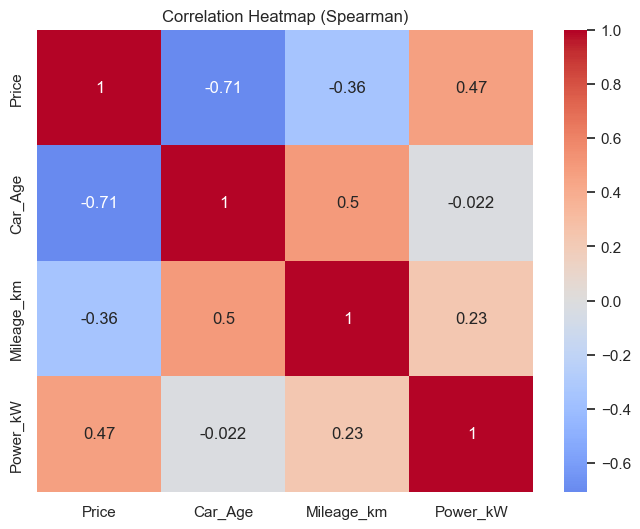

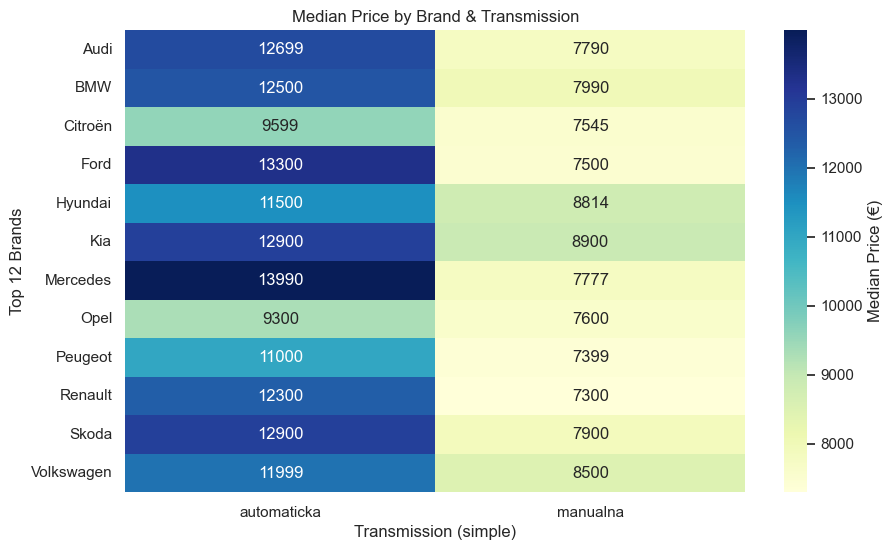

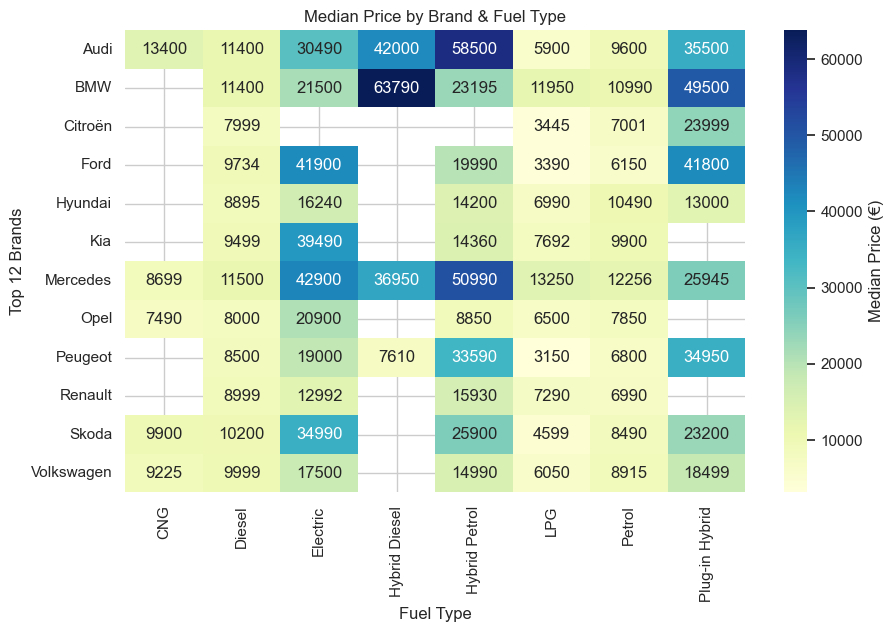

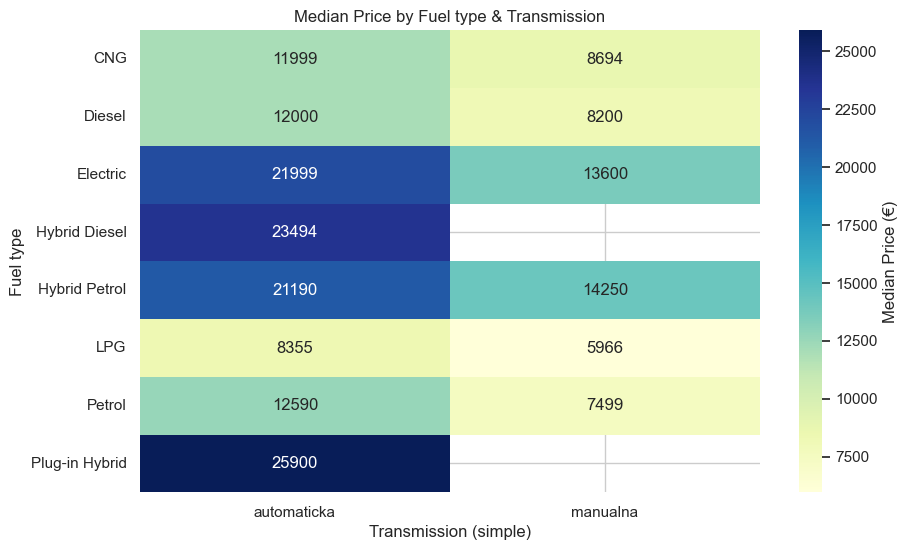

In [15]:
### 7. Correlation Heatmaps & Feature Relationships
# Spearman correlation of numerical features

num_cols = ["Price", "Car_Age", "Mileage_km", "Power_kW"]
corr = df_eda[num_cols].corr(method="spearman")

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Spearman)")
plt.show()

# Example cross-tabs: 
# Brand × Transmission (median price)
top_12brands = top_brands[:12]
df_top12 = df_eda[df_eda["Brand"].isin(top_12brands)]

pivot = (
    df_top12.groupby(["Brand", "Transmission_simple"])["Price"]
          .median()
          .unstack()
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cbar_kws={"label": "Median Price (€)"}, fmt=".0f", cmap="YlGnBu")
plt.title("Median Price by Brand & Transmission")
plt.xlabel("Transmission (simple)")
plt.ylabel("Top 12 Brands")
plt.show()

# Brand × Fuel (median price)
pivot2 = (
    df_top12.groupby(["Brand", "Fuel"])["Price"]
          .median()
          .unstack()
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot2, annot=True, cbar_kws={"label": "Median Price (€)"}, fmt=".0f", cmap="YlGnBu")
plt.title("Median Price by Brand & Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Top 12 Brands")
plt.show()

# Fuel × Transmission_simple
pivot3 = (
    df_top12.groupby(["Fuel", "Transmission_simple"])["Price"]
          .median()
          .unstack()
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot3, annot=True, cbar_kws={"label": "Median Price (€)"}, fmt=".0f", cmap="YlGnBu")
plt.title("Median Price by Fuel type & Transmission")
plt.xlabel("Transmission (simple)")
plt.ylabel("Fuel type")
plt.show()

### Observations:
**Correlation Heatmap (Spearman)**

* Car Age has the strongest negative correlation with Price (≈ -0.71), meaning older cars are significantly cheaper.
* Mileage is also negatively correlated with Price (≈ -0.36), though weaker than age, suggesting age explains price drops better than mileage.
* Power (kW) has a moderate positive correlation with Price (≈ +0.47), so more powerful cars tend to be more expensive.
* Car Age and Mileage are moderately correlated (≈ +0.5), which makes sense as older cars usually accumulate higher mileage.

**Brand and Transmission Heatmap**

* Across brands, automatic cars consistently have higher median prices than manual ones (e.g., Mercedes €13.9k vs €7.7k, Audi €12.7k vs €7.8k).
* The price premium for automatics is especially large in premium brands (Mercedes, BMW, Audi), while it is smaller for mainstream brands (Peugeot, Renault, Opel).
* This reflects both demand (buyers willing to pay more for automatics in higher-end cars) and supply (manuals are more common in budget brands).

**Brand and Fuel Heatmap**

* Premium brands (BMW, Audi, Mercedes) show very high medians for electric and hybrids, confirming that these drivetrains are still positioned as luxury/high-tech options.
* Mass-market brands (Skoda, VW, Opel) offer much cheaper petrol/diesel cars, but their hybrids also push them into a higher price segment.
* Alternative fuels (LPG, CNG) consistently appear at the bottom of the price spectrum — usually older or economy-focused models.

**Fuel Type × Transmission**

* For nearly all fuel types, automatic cars are more expensive than manual ones, sometimes by a large margin (e.g. electric cars: €22k auto vs €13.6k manual).
* Manual gearboxes are mostly confined to petrol/diesel cars, while hybrids and EVs are dominated by automatics.
* This reinforces that automatic transmission is becoming the default for “modern” fuel types, while manuals remain mostly in the budget ICE (internal combustion engine) category.

In [16]:
### 8. VIF Analysis for Multicollinearity
# Keep only Car_Age, drop Year and Year_bin to avoid multicollinearity.
num_cols = ["Car_Age","Mileage_km","Power_kW"]
cat_cols = ["Brand","Body","Fuel","Transmission_simple","Engine_bin"]
# One-hot encode categorical variables
X_num = df_eda[num_cols].apply(pd.to_numeric, errors="coerce")
X_cat = pd.get_dummies(df_eda[cat_cols], drop_first=True, dtype=float)

features_encoded = pd.concat([X_num, X_cat], axis=1)
features_encoded = features_encoded.fillna(0)

X_vif = add_constant(features_encoded)
vif = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

print(vif.head(20))

                Feature          VIF
0                 const  3420.698000
53          Brand_Skoda   385.900301
60     Brand_Volkswagen   333.102342
23           Brand_Ford   194.101800
47        Brand_Peugeot   166.142851
8             Brand_BMW   163.994561
42       Brand_Mercedes   143.799237
46           Brand_Opel   135.866738
7            Brand_Audi   134.568165
26        Brand_Hyundai   133.711791
32            Brand_Kia   112.613207
14        Brand_Citroën   111.802623
50        Brand_Renault   102.994998
22           Brand_Fiat    86.460389
72          Fuel_Diesel    77.278775
84  Engine_bin_EV (0 L)    75.159754
77          Fuel_Petrol    74.656079
51           Brand_Seat    73.701141
73        Fuel_Electric    71.721189
59         Brand_Toyota    69.329342


VIF is very high for some brands (e.g., Brand_Skoda, Brand_VW)
This is likely due to dominance of these brands in the dataset.
However, since Brand is a key predictor of Price, I will keep it, but I will group it by market segment.

In [17]:
# Group brands by market segment
brand_to_segment = {
    # Luxury / Premium
    "Audi": "Luxury", "BMW": "Luxury", "Mercedes": "Luxury",
    "Porsche": "Luxury", "Jaguar": "Luxury", "Lexus": "Luxury",
    "Land Rover": "Luxury", "Maserati": "Luxury", "Bentley": "Luxury",
    "Aston Martin": "Luxury", "Ferrari": "Luxury", "Cadillac": "Luxury",
    "Lincoln": "Luxury", "Alpina": "Luxury", "Hongqi": "Luxury",
    
    # Upper Midrange
    "Volkswagen": "Upper Midrange", "Volvo": "Upper Midrange",
    "Mini": "Upper Midrange", "Cupra": "Upper Midrange",
    
    # Mainstream / Midrange
    "Skoda": "Midrange", "Kia": "Midrange", "Hyundai": "Midrange",
    "Toyota": "Midrange", "Ford": "Midrange", "Peugeot": "Midrange",
    "Renault": "Midrange", "Citroën": "Midrange", "Seat": "Midrange",
    "Mazda": "Midrange", "Honda": "Midrange", "Nissan": "Midrange",
    "Subaru": "Midrange",
    
    # Budget / Economy
    "Dacia": "Budget", "Fiat": "Budget", "Opel": "Budget",
    "Suzuki": "Budget", "Lada": "Budget", "SsangYong": "Budget",
    
    # Commercial / Utility
    "MAN": "Commercial", "Iveco": "Commercial", "Isuzu": "Commercial",
    "Piaggio": "Commercial",
    
    # US Brands
    "Jeep": "US SUV", "Dodge": "US SUV", "Chevrolet": "US SUV",
    "Chrysler": "US SUV", "Buick": "US SUV",
    
    # Electric Focused
    "Tesla": "Electric Focused", "Smart": "Electric Focused", "MG": "Electric Focused",
    
    # Other / Rare
    "DS": "Other", "Dongfeng": "Other", "Mahindra": "Other", "Simca": "Other",
    "Daewoo": "Other", "Infiniti": "Other",
    "Abarth": "Other", "Alfa Romeo": "Other",
}

# Apply mapping to DataFrame
df_eda["Brand_Segment"] = df_eda["Brand"].map(brand_to_segment).fillna("Other")

# Check results
print(df_eda["Brand_Segment"].value_counts())

Brand_Segment
Midrange            9576
Luxury              3045
Upper Midrange      2688
Budget              2052
Other                226
US SUV               188
Commercial            71
Electric Focused      56
Name: count, dtype: int64


In [18]:
# Let's check VIF again with Brand_Segment
cat_cols = ["Brand_Segment","Body","Fuel","Transmission_simple","Engine_bin"]
X_num = df_eda[num_cols].apply(pd.to_numeric, errors="coerce")
X_cat = pd.get_dummies(df_eda[cat_cols], drop_first=True, dtype=float)

features_encoded = pd.concat([X_num, X_cat], axis=1)
features_encoded = features_encoded.fillna(0)

# Check vif again
X_vif = add_constant(features_encoded)
vif = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

print(vif.head(20))

                   Feature         VIF
0                    const  447.655264
21             Fuel_Diesel   76.697275
33     Engine_bin_EV (0 L)   74.836366
26             Fuel_Petrol   74.034532
22           Fuel_Electric   71.445273
11              Body_combi   19.858711
13          Body_hatchback   17.893951
17                Body_suv   16.168246
27     Fuel_Plug-in Hybrid   10.061093
20            Body_van/mpv    9.045708
16              Body_sedan    8.621026
19            Body_utility    5.238625
25                Fuel_LPG    4.699694
24      Fuel_Hybrid Petrol    4.131323
3                 Power_kW    3.383339
6     Brand_Segment_Luxury    2.861411
18            Body_unknown    2.787901
7   Brand_Segment_Midrange    2.762678
31    Engine_bin_2.2–3.0 L    2.617309
12              Body_coupe    2.432735


In [19]:
# Encode Fuel and Body with numbers for simplicity
# Define manual mapping for Fuel
fuel_mapping = {
    "Petrol": 0,
    "Diesel": 1,
    "Electric": 2,
    "LPG": 3,
    "CNG": 4,
    "Hybrid Petrol": 5,
    "Hybrid Diesel": 6,
    "Plug-in Hybrid": 7,
    "Unknown": 8
}

# Apply mapping
df_eda["Fuel_encoded"] = df_eda["Fuel"].map(fuel_mapping)

print(df_eda[["Fuel", "Fuel_encoded"]].head(10))
print("Unique encoded values:", df_eda["Fuel_encoded"].unique())

# Define manual mapping for Body
body_mapping = {
    "combi": 0,
    "hatchback": 1,
    "suv": 2,
    "van/mpv": 3,
    "sedan": 4,
    "utility": 5,
    "unknown": 6,
    "coupe": 7,
    "cabrio": 8,
    "other": 9,
    "pickup": 10
}

# Apply mapping
df_eda["Body_encoded"] = df_eda["Body"].map(body_mapping)

print(df_eda[["Body", "Body_encoded"]].head(10))
print("Unique encoded values:", df_eda["Body_encoded"].unique())

            Fuel  Fuel_encoded
0         Petrol             0
1         Diesel             1
2         Diesel             1
3  Hybrid Diesel             6
4         Petrol             0
5         Diesel             1
6         Petrol             0
7       Electric             2
8         Petrol             0
9         Petrol             0
Unique encoded values: [0 1 6 2 5 7 3 4 8]
        Body  Body_encoded
0      sedan             4
1        suv             2
2  hatchback             1
3        suv             2
4  hatchback             1
5    van/mpv             3
6      combi             0
7        suv             2
8  hatchback             1
9      combi             0
Unique encoded values: [ 4  2  1  3  0  7  8  9  6  5 10]


In [22]:
# Use Fuel_encoded and Body_encoded for VIF check
cat_cols = ["Brand_Segment","Transmission_simple","Engine_bin"]
num_cols = ["Car_Age","Mileage_km","Power_kW","Fuel_encoded","Body_encoded"]

X_num = df_eda[num_cols].apply(pd.to_numeric, errors="coerce")
X_cat = pd.get_dummies(df_eda[cat_cols], drop_first=True, dtype=float)

features_encoded = pd.concat([X_num, X_cat], axis=1)
features_encoded = features_encoded.fillna(0)

# Check vif again
X_vif = add_constant(features_encoded)
vif = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

print(vif.head(20))

                           Feature        VIF
0                            const  42.108024
3                         Power_kW   3.007817
8             Brand_Segment_Luxury   2.745028
9           Brand_Segment_Midrange   2.723278
15            Engine_bin_2.2–3.0 L   2.260616
12    Brand_Segment_Upper Midrange   2.135823
14            Engine_bin_1.8–2.2 L   1.770941
16               Engine_bin_>3.0 L   1.675979
13    Transmission_simple_manualna   1.590624
2                       Mileage_km   1.558214
18               Engine_bin_≤1.2 L   1.500811
1                          Car_Age   1.495702
4                     Fuel_encoded   1.363988
17             Engine_bin_EV (0 L)   1.353081
7   Brand_Segment_Electric Focused   1.148970
11            Brand_Segment_US SUV   1.123394
10             Brand_Segment_Other   1.121462
5                     Body_encoded   1.101335
6         Brand_Segment_Commercial   1.078723


### Multicollinearity (VIF) observations:

I used VIF to make the **linear baselines** stable and interpretable before moving to trees/GBMs.

**What I did**

* Dropped **`Year`** / **`Year_bin`** and kept **`Car_Age`** (the true depreciation signal).
* Replaced many brand dummies with **`Brand_Segment`** to avoid dominance by Škoda/VW and brand–engine overlaps.
* For diagnostics only, created **`Fuel_encoded`** and **`Body_encoded`** (quick numeric placeholders) to re-check collinearity.
* Tested VIF again **including `Engine_bin`** to see if segmentation/encodings broke the near-deterministic links (e.g., Tesla ↔ EV).

**Result (this last VIF table)**

* All non-intercept features are **VIF < 5** (most < 3).
* The **`const`** row’s VIF is not meaningful and can be ignored.
* The largest remaining VIFs (e.g., **`Power_kW` ≈ 3.0**, **`Brand_Segment_*` ≈ 2.7**) are well within common guidelines.

**Decision for modeling**

* Even though VIFs are acceptable **with `Engine_bin` present**, I **exclude `Engine_bin`** from the final models because:

  * It overlaps with **`Fuel`** and **`Brand_Segment`** (redundant signal).
  * Some levels are **rare**, which would create sparse/unstable dummies.
  * Simpler feature space → leaner pipelines and less risk of overfitting.
* Final feature set for modeling:
  **Numerical:** `Car_Age`, `Mileage_km`, `Power_kW`
  **Categorical (OHE):** `Fuel`, `Body`, `Brand_Segment`
  (Trees/GBMs don’t *require* low VIF, but using the same clean set keeps results consistent.)


### Data collection caveat:
    This dataset was scraped from autobazar.sk on a single day. Car listings can change quickly, and prices vary with seasonality, promotions, or local supply/demand shifts.
    If the same data were collected repeatedly over a month (e.g., weekly snapshots), the analysis would likely smooth out anomalies and provide a more stable picture of features relationships